# 

# PadeOpsIO overview

PadeOpsIO is a tool for loading, visualizing, and analyzing data from [PadeOps](https://github.com/FPAL-Stanford-University/PadeOps), an LES and DNS box code. 

## Dependencies
------
Aside from standard python library packages, PadeOpsIO requires: <br>
* `numpy` <br>
* `scipy` <br>
* `matplotlib` <br>

Start with importing the code. Once installed from Github, import the module: 
```
import padeopsIO as pio
```

In [1]:
import padeopsIO as pio

The `budgetIO.py` file is the main submodule for loading files. Within `budgetIO.py`, the `BudgetIO` class imports PadeOps data into Python so it can be read and analyzed. If reading directly from PadeOps output files, 
```
run = pio.BudgetIO(r'DATA DIRECTORY HERE', padeops=True)
```
The directory is expected to contain several files, namely: <br>
* an input file (Fortran namelist) `<FILENAME>.dat` <br>
* a turbine file (Fortran namelist) `./turb/ActuatorDisk_XXXX_input.inp` <br>
* Any associated output files from the simulation

If reading from data exported in `.npz` file format, 
```
run = pio.BudgetIO(r'DATA DIRECTORY HERE', npz=True)
```
and expects the following files: <br>
* a metadata file `<FILENAME>_metadata.npz` <br>
* a data file `<FILENAME>_budgets.npz` <br>

When importing `.npz` files, if the filename is not the same as the directory name, specify the filename with the `filename=` keyword argument. In the cell below, we will import some data from `../test_data` that was exported to `.npz` fileformat from a previous simulation. 

In [2]:
FILENAME = 'example'
DATA_DIR = r'../test_data'
case = pio.BudgetIO(DATA_DIR, filename=FILENAME, npz=True)
print(case)

Now `case` is a `BudgetIO` object that refers to an object that references the exported data saved in `../test_data/example_budgets.npz` with metadata stored in `../test_data/example_metadata.npz`. We can show the metadata from the input file by printing `run.input_nml` ("nml" short for "namelist"; this is the file that was originall input to the Fortran code, stored as a Python dictionary)

In [3]:
print(case.input_nml)

{'input': {'inputdir': '/scratch/08445/tg877441/control/z0_2', 'outputdir': '/scratch/08445/tg877441/control/prod_sweep_01/yaw_00_cT_09', 'nx': 384, 'ny': 256, 'nz': 256, 'tstop': 12900.0, 'cfl': 1.0, 'dt': 0.001, 'prow': 0, 'pcol': 0, 'userestartfile': 1, 'restartfile_tid': 4000, 'restartfile_rid': 2}, 'numerics': {'advectionterm': 1, 'computestokespressure': 1, 'numericalschemevert': 1, 'usedealiasfiltervert': 0, 't_divergencecheck': 100, 'timesteppingscheme': 2, 'useexhaustivefft': 1}, 'io': {'runid': 5, 't_restartdump': 1000, 't_datadump': 1000, 'iotype': 0, 'dumpplanes': 0, 't_planedump': 10, 't_start_planedump': 3500, 't_stop_planedump': 5000, 'dump_nu_sgs': 1, 'dump_kappa_sgs': 1}, 'stats': {'tid_statsdump': 5000, 'tid_compstats': 1, 'tsimstartstats': 20.0, 'normstatsbyustar': 0, 'computespectra': 0, 'timeavgfullfields': 0}, 'os_interactions': {'usesysteminteractions': 1, 'tsysteminteractions': 10, 'controldir': 'null'}, 'physics': {'isinviscid': 1, 'usecoriolis': 1, 'useextrafo

## Loading data
--------------
Let's load some data from the budgets file. We can load entire (time-averaged) budgets of the full flow field, or of just a "slice" (either 1D, 2D, or 3D) through some of the flow field. Typically, the computational domain is much larger than the domain of interest, so let's just load a 3D slice cut into the full domain. 

(For loading full budgets, see `case.read_budgets()`)

We can see what quantities we have access to by calling `case.existing_terms()`. Then we create a "slice" of the existing data (here, just time-averaged velocity fields were saved) with the function `slice()`. 

In [4]:
print(case.existing_terms())

sl = case.slice(budget_terms=['ubar'], xlim=[-2, 12], ylim=[-2, 2], zlim=0)
print(sl.keys())

['wbar', 'vbar', 'ubar']
dict_keys(['keys', 'ubar', 'x', 'y', 'z', 'extent'])


Now we have a dictionary `sl` with a 2D array `'ubar'`. The other keys in the dictionary `'x'`, `'y'`, and `'z'` correspond with the the grid points at which the slice is taken. Here, `zlim=0` means that `z` is just a scalar, but because `xlim` and `ylim` are ranges, `x` and `y` will be arrays. 

We can plot this 2D field as an image: 

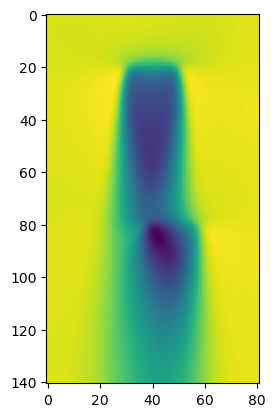

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(sl['ubar'])
plt.show()

This is supposed to be two wind turbine wakes, so we need to fix some things. 
1. Fortran indexes in ijk format (instead of xy format), so if we are displaying data with `plt.imshow`, the array needs to be transposed. <br>
2. We can set the extents of the image to correspond with the physical domain by using the `extent` keyword. <br>
3. Add labels to make the plot. There is a dictionary returned by `pio.budgetkey.key_labels()` that matches the keys used in the budgets and slices for field variables with appropriate variable names (e.g. `'ubar'` matches to $\bar{u}/U$). 

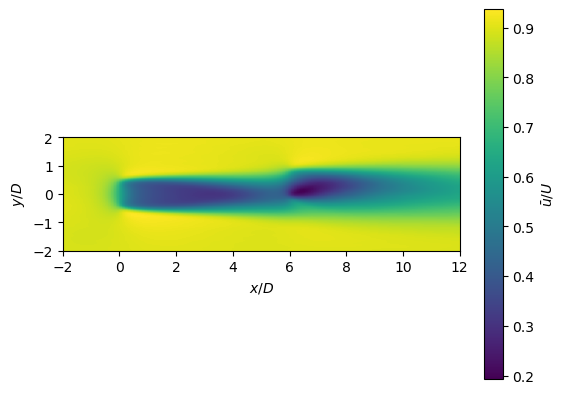

In [6]:
keylab = pio.budgetkey.key_labels()

fig, ax = plt.subplots()
im = ax.imshow(sl['ubar'].T, extent=sl['extent'], origin='lower')

ax.set_xlabel(keylab['x'])
ax.set_ylabel(keylab['y'])
plt.colorbar(im, label=keylab['ubar'])  # adds a colorbar

plt.show()

Calling `run.slice` loads the budgets automatically because they are needed to construct the slice. Once budgets are loaded, they stay loaded in the `budget` field of the `BudgetIO` object. We can access the same data as in the plot above from the budget dictionary in the object variables. 

The problem is that the array `run.budget['ubar']` is 3D and is indexed from zero to $n - 1$, where $n$ is the number of points along the $x$, $y$, or $z$ axis. These data happens to contain 256 points in $x$ and $y$, and 128 points in $z$. This example data has a wind turbine located at the origin of the turbine-normalized axes, but the index at which the $z=0$ plane lies is not trivial. We can use `run.get_xids` to query the index, and plot the data directly from the budgets. We could also use `run.get_xids` to get limits on the $x$ and $y$ indices, which is shown below. 

()

In [28]:
xids = 3 #[5,5]
import numpy as np
tmp = np.squeeze(np.unique(xids))


0

Shape of velocity fields:  (171, 81, 40)
Plotting xy-slice at zid = [19]


TypeError: Invalid shape (1, 81, 141) for image data

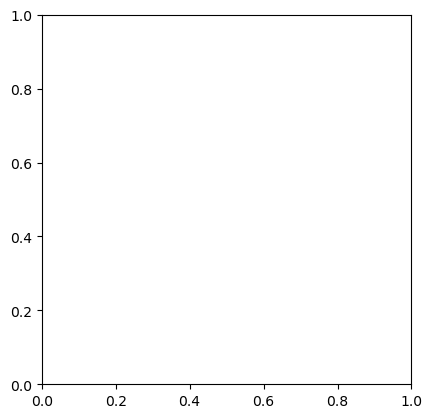

In [7]:
print("Shape of velocity fields: ", case.budget['ubar'].shape)

xid, yid, zid = case.get_xids(x=[-2, 12], y=[-2, 2], z=0, return_slice=True)
ubar_xy = case.budget['ubar'][xid, yid, zid]
extent_xy = [
    case.xLine[xid].min(), case.xLine[xid].max(), 
    case.yLine[yid].min(), case.yLine[yid].max()
    ]

print('Plotting xy-slice at zid =', zid)

fig, ax = plt.subplots()
im = ax.imshow(ubar_xy.T, extent=extent_xy, origin='lower')

ax.set_xlabel(keylab['x'])
ax.set_ylabel(keylab['y'])
plt.colorbar(im, label=keylab['ubar'])  # adds a colorbar

plt.show()

There are a few things to observe about this (otherwise rather boring flow field). 

First, PadeOps is a pseudo-spectral code which uses Fourier transforms to compute the Navier-Stokes equations. This requires periodicity, so there is a "fringe region" beyond $x/D \approx 15$ in which perturbations in the flow are actively being "smoothed out" so the field is periodic in $x$ (the fringe region actually starts at $x/D = 0.75L_x$, which is at $x/D = 13.75$ for the turbine-normalized coordinates here). The problem is already "periodic" in $y$ so there is no fringe region, and PadeOps is using a finite-differencing scheme in the $z$ direction which is slower but does not require spectral derivatives (and therefore periodicity). The fringe region is unphysical (purely for the purpose of running fast, spectral LES) and therefore shouldn't be included in any analysis. 

Second, it is rather boring. There is a turbine at $(x, y) = (0, 0)$, but the flow is mostly laminar despite this being a large eddy simulation. This is because the inflow is turbulence-free and uniform, so turbulence is only "triggered" much farther downstream than the computational domain allows. 

Third, most of the domain is important only for computation (e.g. enforcing periodicty and minimizing flow blockage) but rather boring otherwise, which is the benefit of looking at slices instead of full flow fields. 